## Libaries

In [10]:

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
#Libaries for calculation and processing
from einops import rearrange, repeat
import math
from math import sqrt
from math import ceil
import numpy as np
from sklearn.preprocessing import StandardScaler
#libaries for data importng, formating and handling 
import pandas as pd
#For analysis and plotting
import matplotlib.pyplot as plt
import seaborn as sns
#others
import os
import time
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from data.Dataset import *
from model.Crossformer import *
from exp.ExpFish import *

## Hyperparameters

In [11]:
#DATASET 
ROOT_PATH = "Data/fishes/fish02/s1/"
DATA_PATH = "df_timeseries_red_clusters_s1.csv"
TRAIN_FLAG = "train"
VAL_FLAG = "val"
TEST_FLAG = "test"
SIZE=[100,100,100] #[seq_len, label_len, pred_len]
SCALE = True
SCALE_STATISTIC = True
DATA_SPLIT = [1, 0, 0.0]  # Train, Val, TEST
STRIDE = 25
#DATALOADER 
BATCH_SIZE = 10
SHUFFLE_FLAG = False
NUM_WORKSES = 0
DROP_LAST = False

#MODEL 
DATA_DIM = 2 # number of clusers
IN_LEN   = SIZE[0]
OUT_LEN  = SIZE[2]
SEG_LEN  = 20
WIN_SIZE = 1
FACTOR   = 2
D_MODEL  = 256 
D_FF     = 512
N_HEADS  = 1
E_LAYERS = 1
DROPOUT  = 0.0
BASELINE = False

#Device
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#OPTIMIZER
LR = 0.001

#TRAINING 
NUM_EPOCHS = 10


# Set a seed value
seed_value= 123

# 1. Set `torch` seed for GPU/CPU random number generation
torch.manual_seed(seed_value)


# Experiment synthetic Sinus



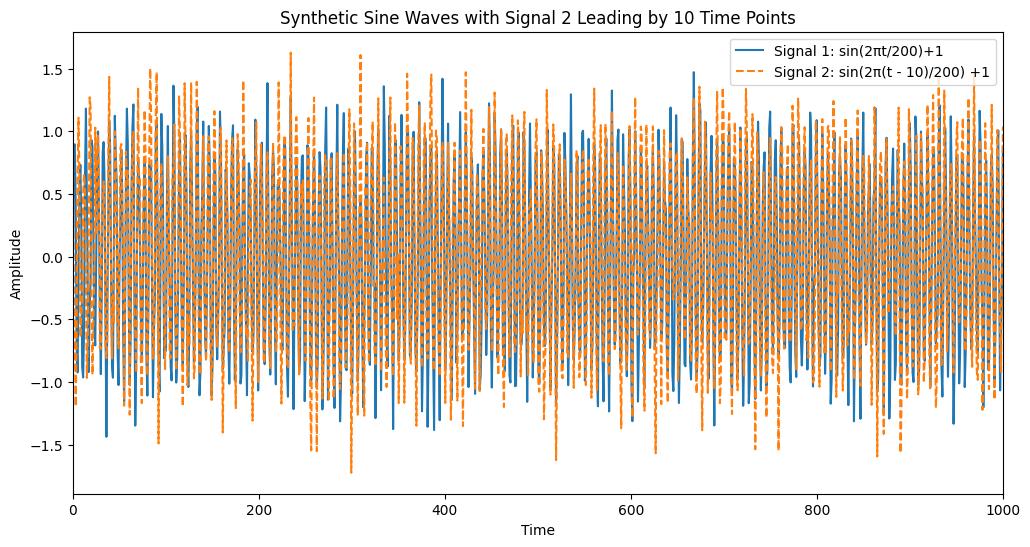

In [12]:
# Generate synthetic data with adjustments
t = np.linspace(0, 1000, 1000)  # Time variable from 0 to 1000
signal_1 = np.sin(2 * np.pi * t / 100) +1  # First sine wave
signal_2 = np.sin(2 * np.pi * (t - 25) / 100) +1 # Second sine wave, shifted to be ahead by 10 time points


# Generate a simple pattern (e.g., sine wave) and add noise to create two related, non-deterministic signals
t = np.linspace(0, 1000, 1000)  # Time vector
signal_1 = np.sin(t) + np.random.normal(0, 0.2, t.shape)  # Signal 1 with noise
signal_2 = np.roll(signal_1, 25) + np.random.normal(0, 0.2, t.shape)  # Signal 2, lagged version of signal 1 with noise


# Plot the adjusted synthetic signals
plt.figure(figsize=(12, 6))
plt.plot(t, signal_1, label='Signal 1: sin(2πt/200)+1')
plt.plot(t, signal_2, label='Signal 2: sin(2π(t - 10)/200) +1', linestyle='--')
plt.legend()
plt.title('Synthetic Sine Waves with Signal 2 Leading by 10 Time Points')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim(0, 1000)  # Limiting x-axis to show the leading effect more clearly
plt.show()



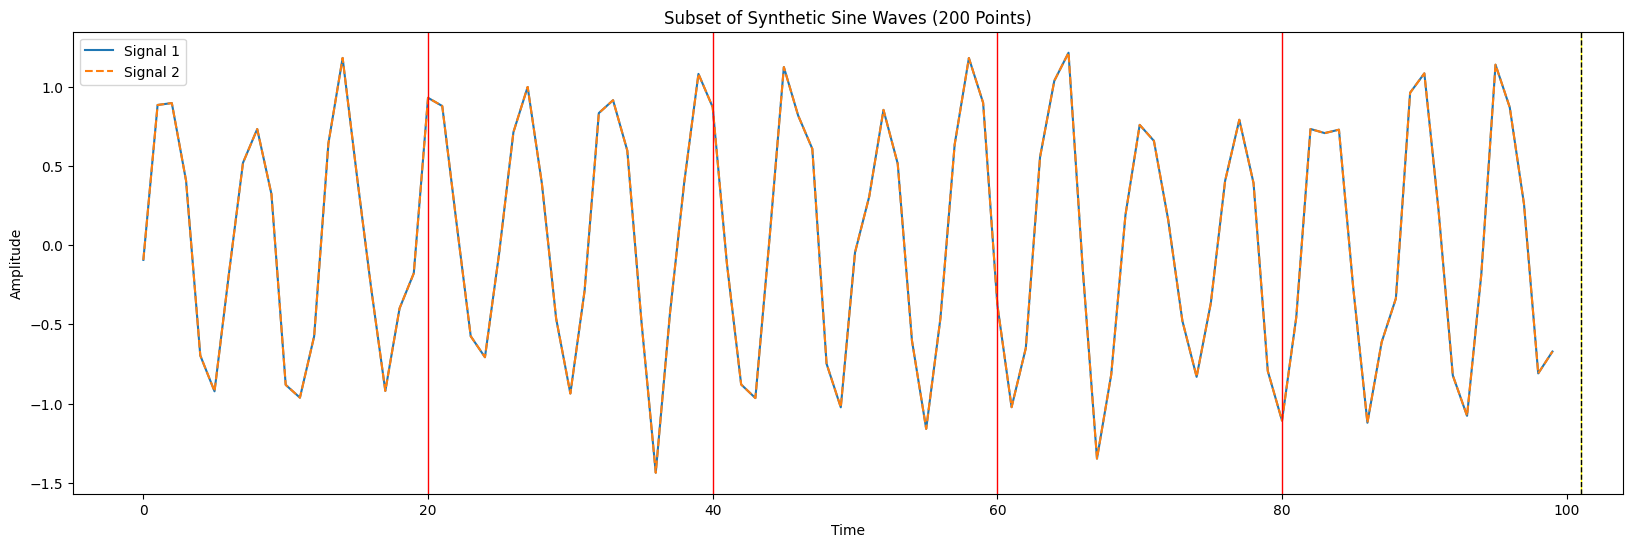

,Signal_1,Signal_2
0,-0.093350,-0.093350
1,0.884495,0.884495
2,0.896466,0.896466
3,0.406605,0.406605
4,-0.696979,-0.696979
...,...,...
195,0.244649,0.244649
196,1.093047,1.093047
197,0.661833,0.661833
198,-0.425025,-0.425025


In [13]:

# Creating a pandas DataFrame to store the synthetic data
df = pd.DataFrame({
    'Signal_1': signal_1,
    'Signal_2': signal_1,
    #'Signal_3': signal_2,
    #'Signal_4': signal_2,
    
})

# Display the first few rows of the DataFrame
df.head()
len(df)


# Load 200 points for each of the signals from the DataFrame
df_subset = df.iloc[:100]

# Plot the subset of data for both signals
plt.figure(figsize=(20, 6))
plt.plot( df_subset['Signal_1'], label='Signal 1')
plt.plot( df_subset['Signal_2'], label='Signal 2', linestyle='--')
for x in range(SEG_LEN, SIZE[0], SEG_LEN):
    plt.axvline(x=x, color='red', linestyle='-', linewidth=1)
 
plt.axvline(x=101, color='yellow', linestyle='-', linewidth=1)   
plt.axvline(x=101, color='black', linestyle='--', linewidth=1)   

plt.legend()
plt.title('Subset of Synthetic Sine Waves (200 Points)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
df.iloc[:200]


In [14]:
synth_data = Dataset_MTS_simplified(df_data=df,stride=STRIDE,size=SIZE)
data_loader_train_synth = DataLoader(
            synth_data,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )

synth_data.__len__()

37

In [15]:
model_synt = Crossformer(
    data_dim=DATA_DIM,
    in_len=IN_LEN,
    out_len=OUT_LEN,
    seg_len=SEG_LEN,
    win_size=WIN_SIZE,
    factor=FACTOR,
    d_model=D_MODEL,
    d_ff=D_MODEL,
    n_heads=N_HEADS,
    e_layers=E_LAYERS,
    dropout=DROPOUT,
    baseline=False,
    device=DEVICE
    
).float()

criterion = nn.MSELoss()
optimizer = optim.Adam(model_synt.parameters(), lr=LR)

## Train

In [16]:
exp = Expfish(model=model_synt,
               data_loader_train=data_loader_train_synth,
               data_loader_test=None,
               data_loader_val=None,
               optimizer=optimizer,
               criterion=criterion,
               num_epochs=NUM_EPOCHS,
               device=DEVICE
               
               )

model_synt = exp.train()







Epoch: 1 cost time: 0.3197469711303711
Epoch: 1, Steps: 4 | Train Loss: 1.0540031 Vali Loss: 0.0000000
Epoch: 2 cost time: 0.3337063789367676
Epoch: 2, Steps: 4 | Train Loss: 0.6191893 Vali Loss: 0.0000000
Epoch: 3 cost time: 0.2677316665649414
Epoch: 3, Steps: 4 | Train Loss: 0.2763976 Vali Loss: 0.0000000
Epoch: 4 cost time: 0.23041558265686035
Epoch: 4, Steps: 4 | Train Loss: 0.1402993 Vali Loss: 0.0000000
Epoch: 5 cost time: 0.3391714096069336
Epoch: 5, Steps: 4 | Train Loss: 0.1045468 Vali Loss: 0.0000000
Epoch: 6 cost time: 0.22333383560180664
Epoch: 6, Steps: 4 | Train Loss: 0.0976348 Vali Loss: 0.0000000
Epoch: 7 cost time: 0.2721672058105469
Epoch: 7, Steps: 4 | Train Loss: 0.0800524 Vali Loss: 0.0000000
Epoch: 8 cost time: 0.259077787399292
Epoch: 8, Steps: 4 | Train Loss: 0.0612343 Vali Loss: 0.0000000
Epoch: 9 cost time: 0.22640299797058105
Epoch: 9, Steps: 4 | Train Loss: 0.0543186 Vali Loss: 0.0000000
Epoch: 10 cost time: 0.31969165802001953
Epoch: 10, Steps: 4 | Train Lo

In [17]:
torch.save(model_synt,"hpc_model/test.pth")